In [1]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import matplotlib.dates as mdates
import datetime as dt

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

plt.style.use('seaborn')

warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
def get_csvs_paths(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            if '.swp' in name:
                continue
            result[name] = dataset_dir + '/' + name
    
    return result

In [3]:
def extract_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    instances = pd.unique(df['instance'])
    
    return df, instances

def extract_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    return df

In [4]:
total = pd.DataFrame()
for name, path in get_csvs_paths('final/train_us3').items():
    df = extract_csv(path)
    if len(total.columns) == 0:
        print('new df - %s' % (name))
        total = df
    else:
        print('merging - %s' % (name))
        total = pd.merge(total, df, on=['time', 'instance'])

total_cols = [
    'time',
    'abgw_write_reqs_total',
    'abgw_read_reqs_total',
    'abgw_stat_reqs_total',
    'abgw_req_errs_total',
    'abgw_iop_latency_ms_count',
    'abgw_detached_files_rate',
    'abgw_detached_files',
    'abgw_fds',
    'abgw_io_limiting_failures_total',
    'abgw_iop_latency_ms_rate',
    'abgw_iop_latency_ms_sum',
    'abgw_write_rollback_bytes_total',
    'abgw_write_rollback_bytes_rate',
    'abgw_req_errs_rate',
    'abgw_account_lookup_errs_total',
    'instance',
]

total.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)

new df - abgw_iop_latency_ms_count.csv
merging - abgw_detached_files_rate.csv
merging - abgw_detached_files.csv
merging - abgw_iop_latency_ms_sum.csv
merging - abgw_file_lookup_errs_rate.csv
merging - abgw_write_bytes_total.csv
merging - abgw_iop_latency_ms_rate.csv
merging - abgw_write_rollback_bytes_rate.csv
merging - abgw_write_rollback_bytes_total.csv
merging - abgw_account_lookup_errs_rate.csv
merging - abgw_write_reqs_total.csv
merging - abgw_account_pull_errs_rate.csv
merging - abgw_account_pull_errs_total.csv
merging - abgw_account_lookup_errs_total.csv
merging - abgw_fds.csv
merging - abgw_io_limiting_failures_total.csv
merging - abgw_req_errs_rate.csv
merging - abgw_read_bytes_total.csv
merging - abgw_stat_reqs_total.csv
merging - abgw_read_reqs_total.csv
merging - abgw_io_limiting_failures_rate.csv
merging - abgw_req_errs_total.csv


In [5]:
total.drop(['account_pull_errs_rate', 'account_pull_errs_total'], inplace=True, axis=1)
total.columns

Index([u'time', u'iop_latency_ms_count', u'instance', u'detached_files_rate',
       u'detached_files', u'iop_latency_ms_sum', u'file_lookup_errs_rate',
       u'write_bytes_total', u'iop_latency_ms_rate',
       u'write_rollback_bytes_rate', u'write_rollback_bytes_total',
       u'account_lookup_errs_rate', u'write_reqs_total',
       u'account_lookup_errs_total', u'fds', u'io_limiting_failures_total',
       u'req_errs_rate', u'read_bytes_total', u'stat_reqs_total',
       u'read_reqs_total', u'io_limiting_failures_rate', u'req_errs_total'],
      dtype='object')

In [7]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92793 entries, 0 to 92792
Data columns (total 22 columns):
time                          92793 non-null datetime64[ns]
iop_latency_ms_count          92793 non-null int64
instance                      92793 non-null object
detached_files_rate           92793 non-null float64
detached_files                92793 non-null int64
iop_latency_ms_sum            92793 non-null float64
file_lookup_errs_rate         92793 non-null float64
write_bytes_total             92793 non-null int64
iop_latency_ms_rate           92793 non-null float64
write_rollback_bytes_rate     92793 non-null float64
write_rollback_bytes_total    92793 non-null int64
account_lookup_errs_rate      92793 non-null float64
write_reqs_total              92793 non-null int64
account_lookup_errs_total     92793 non-null int64
fds                           92793 non-null int64
io_limiting_failures_total    92793 non-null int64
req_errs_rate                 92793 non-null float64


In [8]:
instances = pd.unique(total['instance'])
print('amount of instances %d' %(len(instances)))

amount of instances 24


In [9]:
example_node = total[total['instance'] == instances[0]]
example_node = example_node.drop(['time', 'instance'], axis=1)

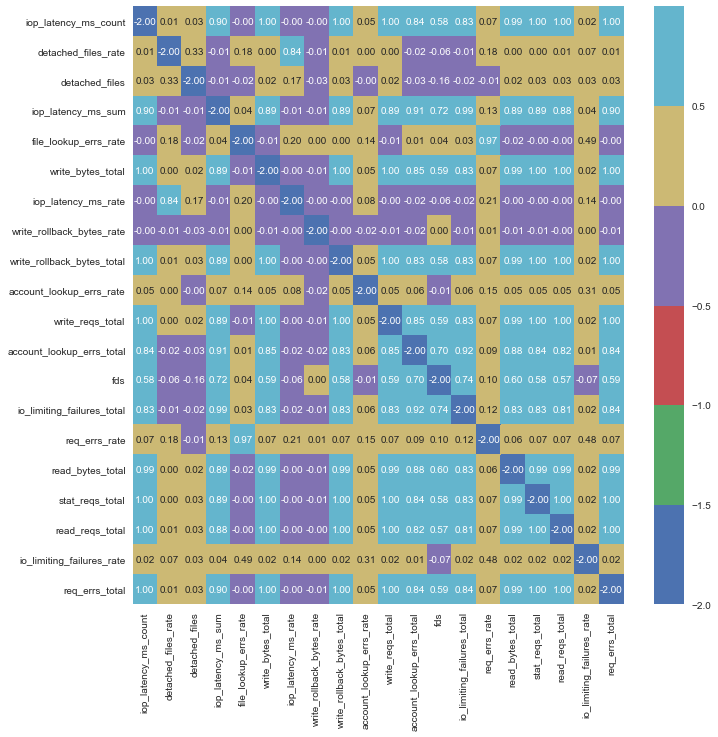

In [10]:
corrs = example_node.corr()
np.fill_diagonal(corrs.values, -2)
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrs, annot=True, fmt=".2f", cmap=sns.color_palette("deep"), ax=ax)

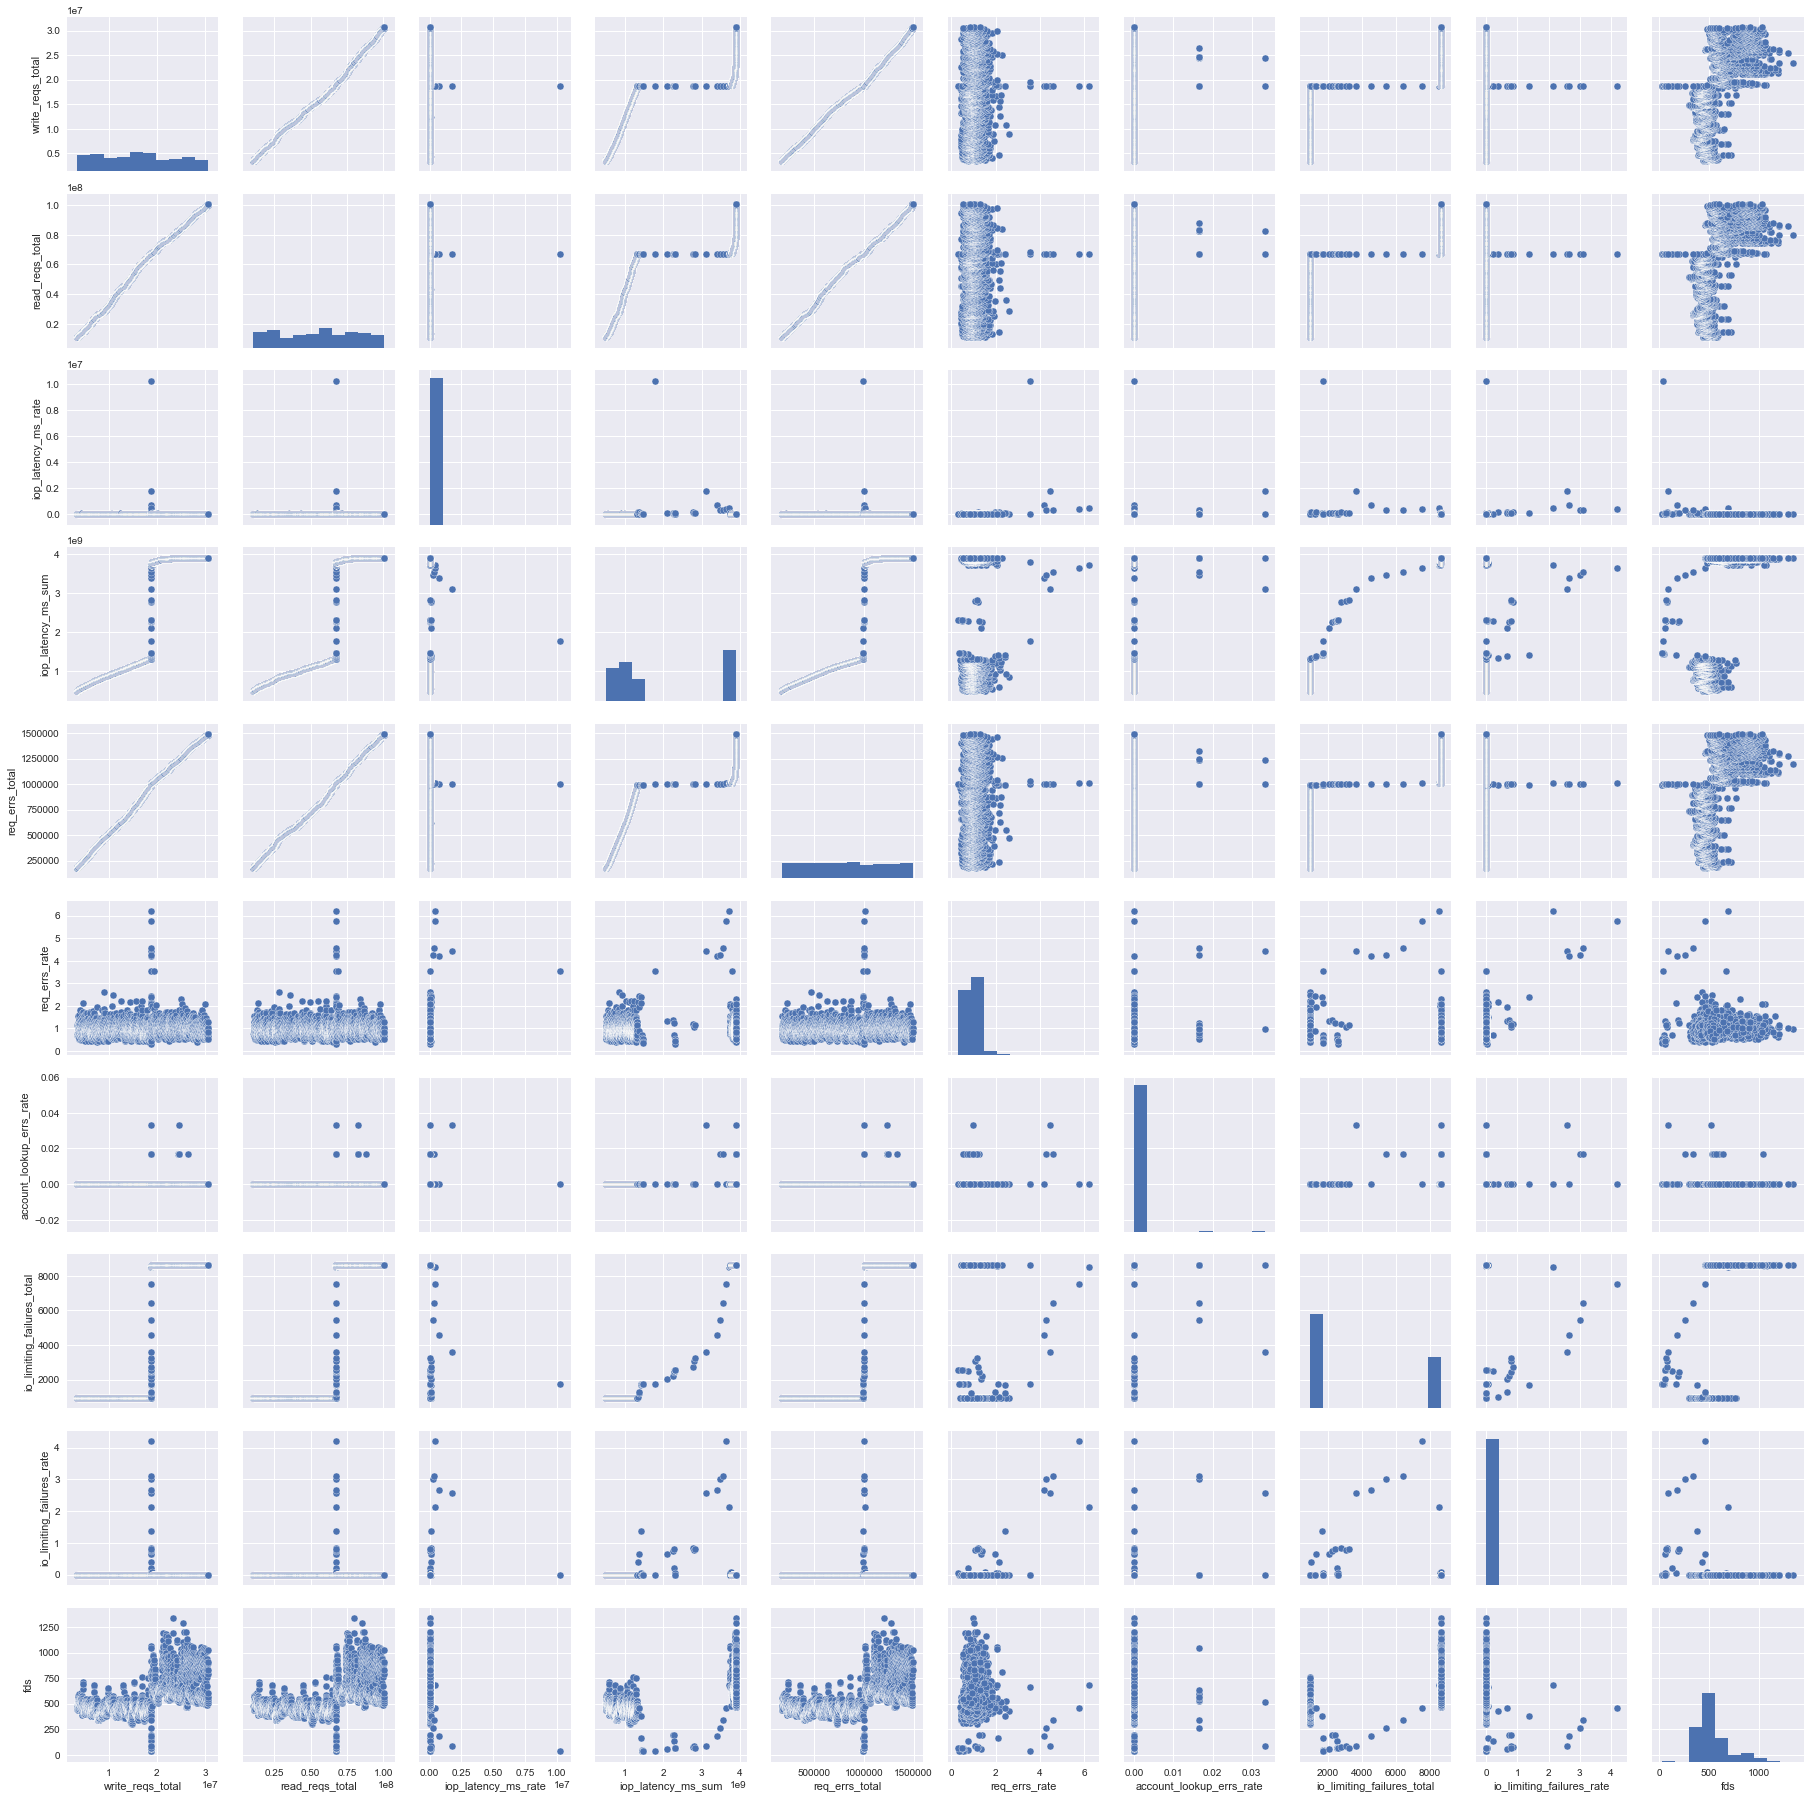

In [10]:
key_cols = ['write_reqs_total',
            'read_reqs_total',
            'iop_latency_ms_rate',
            'iop_latency_ms_sum',
            'req_errs_total',
            'req_errs_rate',
            'account_lookup_errs_rate',
            'io_limiting_failures_total',
            'io_limiting_failures_rate',
            'fds']
sns.pairplot(example_node[key_cols])

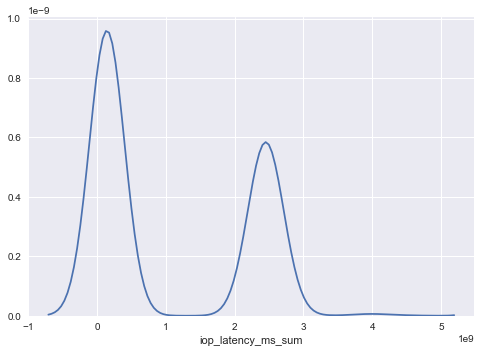

In [56]:
sns.distplot(example_node['iop_latency_ms_sum'], hist=False)

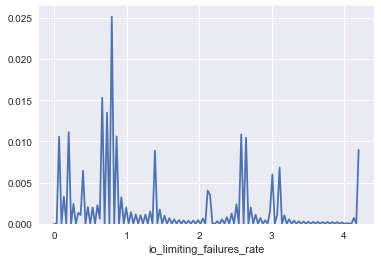

In [12]:
sns.distplot(example_node['io_limiting_failures_rate'], hist=False)

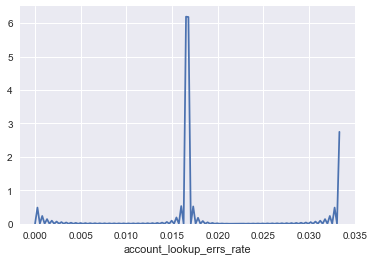

In [13]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

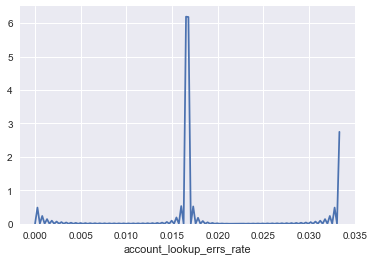

In [14]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

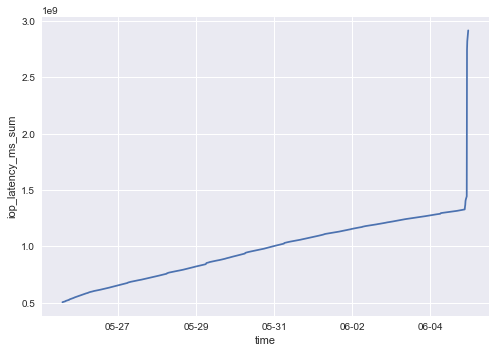

In [15]:
plt.style.use('seaborn')
example_node = total[total['instance'] == instances[11]]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(example_node['time'], example_node['iop_latency_ms_sum'])
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

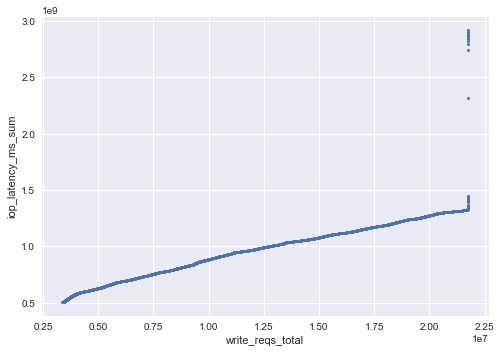

In [16]:
plt.plot(example_node['write_reqs_total'], example_node['iop_latency_ms_sum'], linestyle='none', marker='o',
         markersize=3)
plt.xlabel('write_reqs_total')
plt.ylabel('iop_latency_ms_sum')
plt.show()

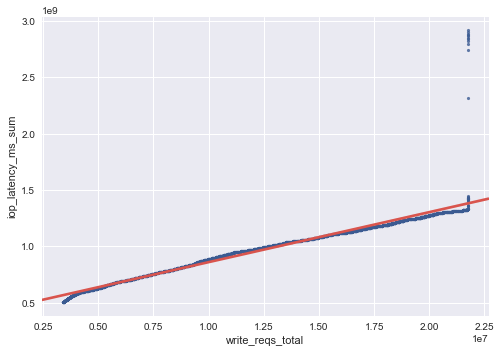

In [17]:
sns.regplot(x='write_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

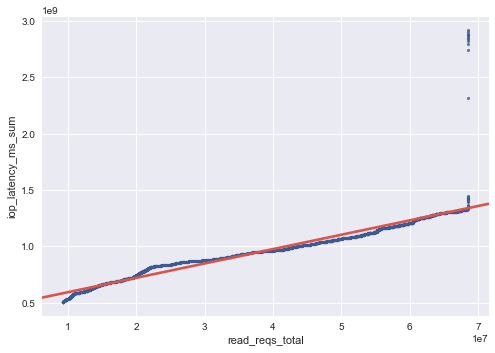

In [18]:
sns.regplot(x='read_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

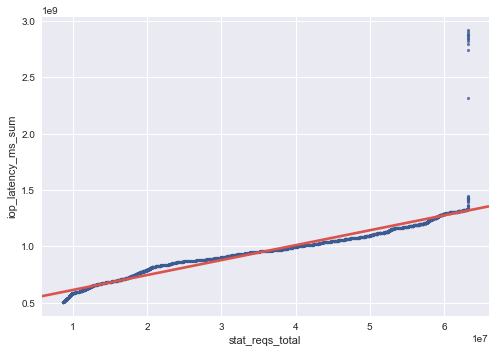

In [19]:
sns.regplot(x='stat_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

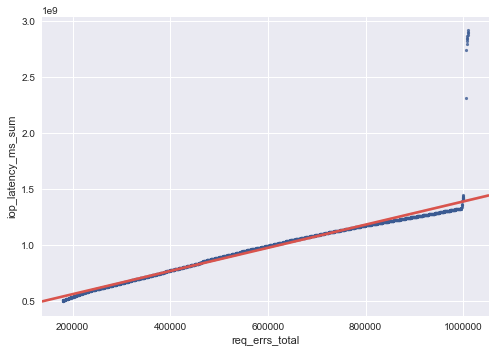

In [20]:
sns.regplot(x='req_errs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

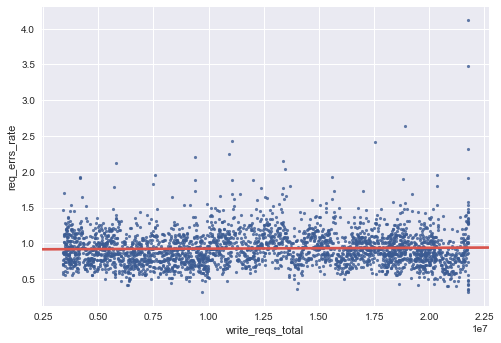

In [21]:
sns.regplot(x='write_reqs_total', y='req_errs_rate', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

In [22]:
train_data = example_node[-1000:-500]
test_data = example_node[-500:]

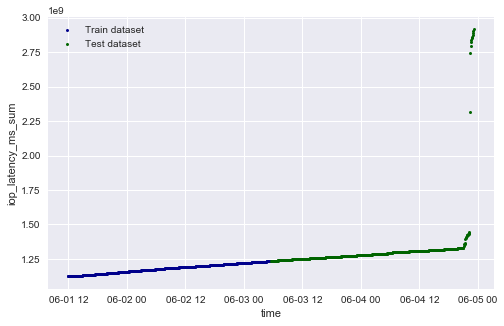

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [24]:
def detect_anomaly(row):
    if row['upper_border'] < row['iop_latency_ms_sum']:
        return 1
    
    return 0

predictors = [
    'read_reqs_total',
    'write_reqs_total',
    'read_reqs_total',
    'write_bytes_total',
    'read_bytes_total',
]

regression_model = linear_model.RANSACRegressor()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

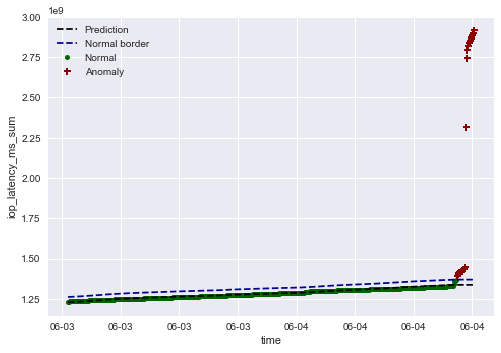

In [25]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(test_data['time'], test_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

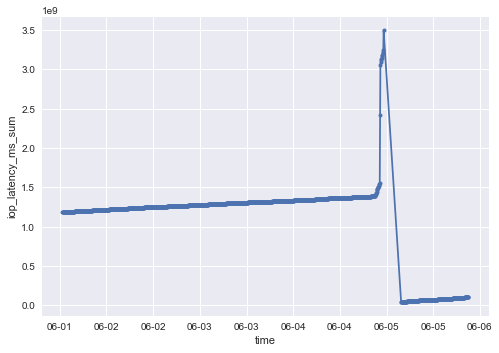

In [26]:
example_node = total[total['instance'] == instances[3]][2000:3200]
train_data = example_node[:700]
test_data = example_node[700:]

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

plt.plot(example_node['time'], example_node['iop_latency_ms_sum'], marker='o', markersize=4)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

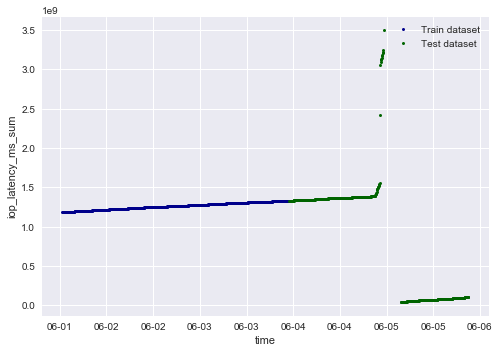

In [27]:
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [28]:
regression_model = linear_model.RANSACRegressor()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

last_anomaly_index = anomaly_data.index.max()
before_anomaly_indexes = [x for x in normal_data.index if x <= last_anomaly_index]
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]

before_anomaly_data = test_data.ix[before_anomaly_indexes]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

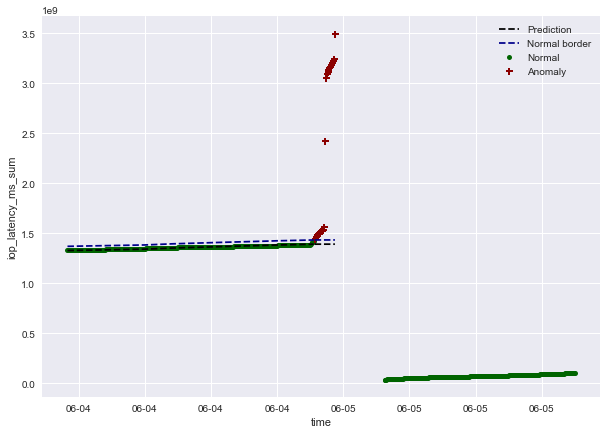

In [423]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

In [29]:
last_anomaly_index = anomaly_data.index.max()
first_anomaly_index = anomaly_data.index.min()
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

with_anomaly_indexes = [x for x in test_data.index if x >= first_anomaly_index]
with_anomaly = test_data.ix[with_anomaly_indexes]

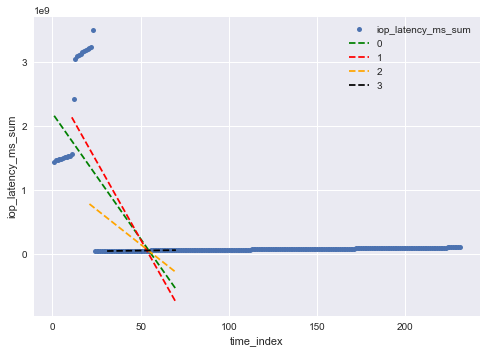

In [30]:
r_values = dict()
iter_limit = 4
shift_length = 10

x = np.arange(1, with_anomaly.shape[0] + 1)
y = with_anomaly['iop_latency_ms_sum']
plt.plot(x, y, linestyle='none', marker='o', markersize=5, label='iop_latency_ms_sum')

colors = ['green', 'red', 'orange', 'black']

x = x[:70]
y = y[:70]

for i in range(iter_limit):
    a, b, r_value, p_value, stderr = ss.stats.linregress(x,y)
    plt.plot(x, a * x + b, linestyle='--', color=colors[i], label=str(i))
    r_values[r_value] = [a, b]
    
    x = x[shift_length:]
    y = y[shift_length:]

plt.ylabel('iop_latency_ms_sum')
plt.xlabel('time_index')
plt.legend()
plt.show()

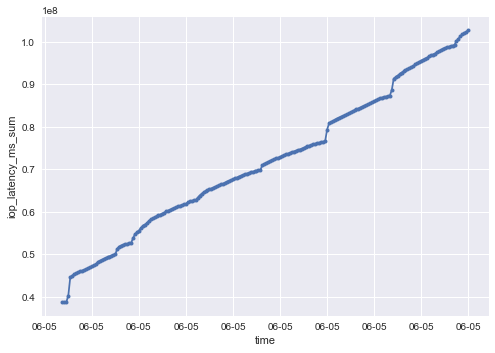

In [94]:
#fig, ax = plt.subplots()
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_sum'], marker='o', markersize=4)
#plt.xlabel('time')
#plt.ylabel('iop_latency_ms_sum')
#plt.show()

In [31]:
regression_model = linear_model.RANSACRegressor()
regression_model.fit(after_anomaly_data[predictors], after_anomaly_data['iop_latency_ms_sum'])

after_anomaly_data['iop_latency_ms_predict'] = regression_model.predict(after_anomaly_data[predictors])
after_anomaly_data['upper_border'] = after_anomaly_data['iop_latency_ms_predict'] + \
                        train_data['iop_latency_ms_sum'].std()

In [99]:
#fig, ax = plt.subplots()
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_sum'], marker='o', markersize=4)
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_predict'], linestyle='--',
#         color='black')
#plt.xlabel('time')
#plt.ylabel('iop_latency_ms_sum')
#plt.legend()
#plt.show()

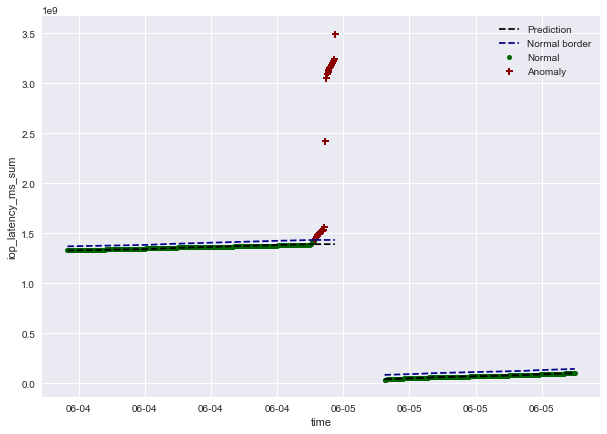

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
         linestyle='--', color='black')
plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
         linestyle='--', color='darkblue')
plt.plot(after_anomaly_data['time'], after_anomaly_data['upper_border'], linestyle='--',
         color='darkblue')
plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_predict'], linestyle='--',
         color='black', linewidth=2)

plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

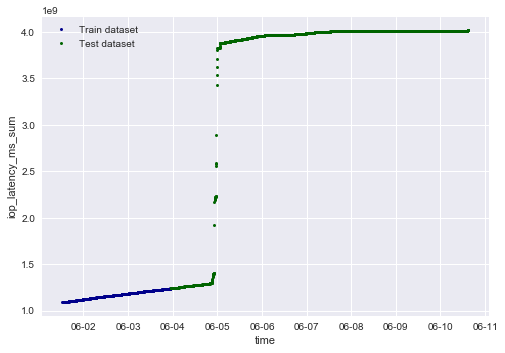

In [33]:
example_node = total[total['instance'] == instances[2]][2000:]
train_data = example_node[:700]
test_data = example_node[700:]

fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [44]:
regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

last_anomaly_index = anomaly_data.index.max()
first_anomaly_idnex = anomaly_data.index.min()
before_anomaly_indexes = [x for x in normal_data.index if x <= first_anomaly_index]
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]

before_anomaly_data = test_data.ix[before_anomaly_indexes]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

In [45]:
after_anomaly_data.shape[0]

0

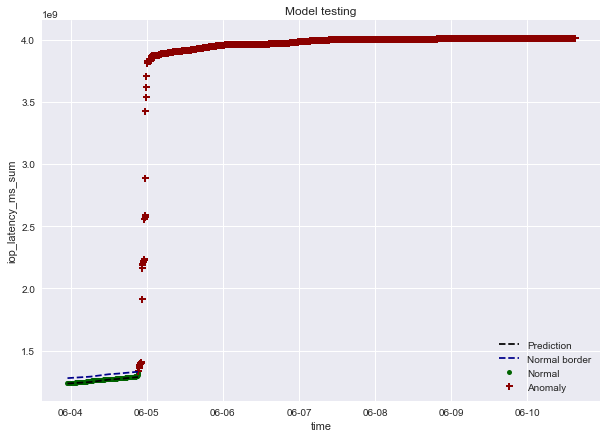

In [46]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

#plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
#                         linestyle='--', color='black')
#plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
#                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.title('Model testing')
plt.show()

In [47]:
with_anomaly_indexes = [x for x in test_data.index if x >= first_anomaly_index]
with_anomaly = test_data.ix[with_anomaly_indexes]

In [48]:
xi = np.arange(1, with_anomaly.shape[0] + 1)
y = with_anomaly['iop_latency_ms_sum']
a, b, r_value, p_value, stderr = ss.stats.linregress(xi,y)

print('r_value with anomaly: %s' % (str(r_value)))

r_value with anomaly: 0.3381453830754776


[0]: r_value = 0.4818355603717919
[1]: r_value = 0.44370649411970503
[2]: r_value = 0.4070247122947076
[3]: r_value = 0.8561313010511703


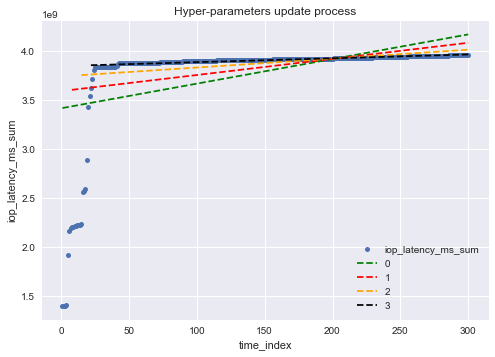

In [49]:
#relearning_data = anomaly_data[:200]
relearning_data = with_anomaly[:300]

r_values = dict()
iter_limit = 4
shift_length = 7
normal_range_start = 1

x = np.arange(1, relearning_data.shape[0] + 1)
y = relearning_data['iop_latency_ms_sum']
plt.plot(x, y, linestyle='none', marker='o', markersize=5, label='iop_latency_ms_sum')

colors = ['green', 'red', 'orange', 'black']

for i in range(iter_limit):
    a, b, r_value, p_value, stderr = ss.stats.linregress(x,y)
    r_values[r_value] = [a, b]
    plt.plot(x, a * x + b, linestyle='--', color=colors[i], label=str(i))
    
    x = x[shift_length:]
    y = y[shift_length:]
    relearning_data = relearning_data[shift_length:]
    
    print('[%s]: r_value = %s' % (i, r_value))

plt.ylabel('iop_latency_ms_sum')
plt.xlabel('time_index')
plt.title('Hyper-parameters update process')
plt.legend()
plt.show()

In [50]:
first_normal_index = relearning_data.index.min()
clean_data_indexes = [x for x in anomaly_data.index if x >= first_normal_index]
anomaly_data_indexes = [x for x in anomaly_data.index if x < first_normal_index]
clean_data = anomaly_data.ix[clean_data_indexes]
anomaly_data = anomaly_data.ix[anomaly_data_indexes]

In [51]:
regression_model.fit(clean_data[predictors], clean_data['iop_latency_ms_sum'])

clean_data['iop_latency_ms_predict'] = regression_model.predict(clean_data[predictors])
clean_data['upper_border'] = clean_data['iop_latency_ms_predict'] + clean_data['iop_latency_ms_sum'].std() * 1.05

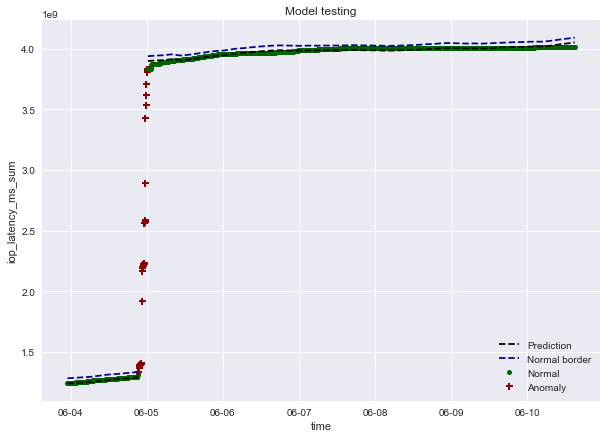

In [52]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(clean_data['time'], clean_data['iop_latency_ms_sum'],
         linestyle='none', marker='o', markersize=5, color='darkgreen')
plt.plot(clean_data['time'], clean_data['iop_latency_ms_predict'],
         linestyle='--', color='black')
plt.plot(clean_data['time'], clean_data['upper_border'],
         linestyle='--', color='darkblue')

plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.title('Model testing')
plt.show()

Simple regression: r_value = -0.5460462941507511


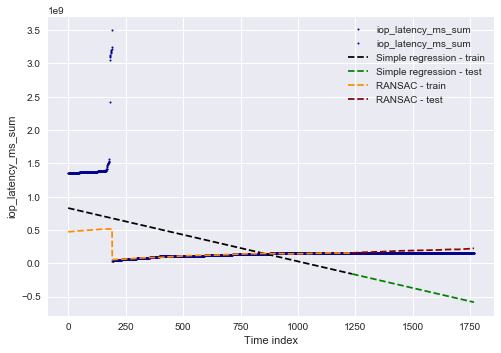

In [67]:
from sklearn.model_selection import train_test_split

example_node = total[total['instance'] == instances[3]][2000:]
train_data = example_node[:800]
test_data = example_node[800:]

look_data = test_data
predict_metric = 'iop_latency_ms_sum'

train_X, test_X, train_y, test_y = train_test_split(look_data[predictors], look_data[predict_metric], shuffle=False,
                                                    test_size=0.3)
train_X['idx'] = np.arange(train_X.shape[0])
test_X['idx'] = np.arange(train_X.shape[0], test_X.shape[0] + train_X.shape[0])

predictors = [
    'read_reqs_total',
    'write_reqs_total',
    'read_reqs_total',
    'write_bytes_total',
]

regression_model = linear_model.RANSACRegressor()
regression_model.fit(train_X[predictors], train_y)
train_X['latency_predict'] = regression_model.predict(train_X[predictors])
test_X['latency_predict'] = regression_model.predict(test_X[predictors])

a, b, r_value, p_value, stderr = ss.stats.linregress(train_X['idx'], train_y)
test_X['simple_predict'] = a * test_X['idx'] + b

print('Simple regression: r_value = %s' % (r_value))

plt.plot(train_X['idx'], train_y, linestyle='none', marker='o', markersize=2, color='darkblue')
plt.plot(test_X['idx'], test_y, linestyle='none', marker='o', markersize=2, color='darkblue')
plt.plot(train_X['idx'], a * train_X['idx'] + b, linestyle='--', color='black', label='Simple regression - train')
plt.plot(test_X['idx'], test_X['simple_predict'], linestyle='--', color='green', label='Simple regression - test')
plt.plot(train_X['idx'], train_X['latency_predict'], linestyle='--', color='darkorange',
         label='RANSAC - train')
plt.plot(test_X['idx'], test_X['latency_predict'], linestyle='--', color='darkred',
         label='RANSAC - test')
plt.xlabel('Time index')
plt.ylabel(predict_metric)
plt.legend()
plt.show()



In [235]:
a, b, r_value, p_value, stderr = ss.stats.linregress(x, look_data['iop_latency_ms_sum'])
print('r_value = %s' % (r_value))

r_value = 0.9961996639162901


In [ ]:
sns.jointplot(y='detached_files_rate', x='fds', data=example_node, kind='reg')

In [ ]:
sns.distplot(example_node['write_rollback_bytes_total'], hist=False)